# Hierarchical Modeling
What models fit the data?

# Setup

### Imports

In [1]:
# Calculation imports
import cmdstanpy
import numpy as np
import pandas as pd
import scipy
from scipy.stats import norm, binned_statistic
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from tqdm import tqdm

In [2]:
# Plotting imports
import matplotlib.pyplot as plt
import seaborn as sns

#### Parameters

In [3]:
config = {
    "bins": 16,
    "min_bin_percentile": 10,
    "eval_sample_size": None,
    "nonden_fit_cols": ["references", "year"],
}

In [4]:
palette = sns.color_palette()

In [5]:
def log_ppd(log_p):
    log_p_max = np.max(log_p)
    log_sum_exp = log_p_max + np.log(np.sum(np.exp(log_p - log_p_max)))
    return log_sum_exp - len(log_p)

#### Load data

In [6]:
df_all = pd.read_csv("../../analysis_data/all_data.csv")
df_all

,density,edginess,references,citations_per_year,is_center,identifier,year,librarian,vectorizer,center,fields_of_study_0
0,1545.550332,0.814415,42,2.250000,False,2e5f3e6c87d1676cdeffc3a2bfbc30b6cd06ed6f,2004,S2,GPT2,hafenLowredshiftLymanLimit2017,Physics
1,1846.261870,0.452021,88,4.625000,False,d7b6cd39dd111afa55a3aa418b7b5459db12988d,2012,S2,GPT2,hafenLowredshiftLymanLimit2017,Physics
2,1703.520959,0.490212,30,0.882353,False,2d62ec65f95435c72ef750b3cff331382c5dca92,2003,S2,GPT2,hafenLowredshiftLymanLimit2017,Physics
3,1901.386693,0.715160,95,8.166667,False,8cebc6e3dcfb543bad48d89112e281a6e11c33c2,2014,S2,GPT2,hafenLowredshiftLymanLimit2017,Physics
4,535.472125,0.885892,94,2.090909,False,59730a4bae4dc53f59341b63fd1e63451c589e9f,2009,S2,GPT2,hafenLowredshiftLymanLimit2017,Physics
...,...,...,...,...,...,...,...,...,...,...,...
537685,48.730838,0.658585,41,3.500000,False,806f77ba7bdf8a3b80cb859fb5f33f57c1d85d24,2018,S2,SciBERT,Andre2018,Mathematics
537686,25.107589,0.721374,38,3.200000,False,f40707d1165c22e185c25e6837977177ee380f2c,2015,S2,SciBERT,Andre2018,Mathematics
537687,41.647954,0.646499,11,1.529412,False,10636ee16779a7521001651164acb5c192d4ad7b,2003,S2,SciBERT,Andre2018,Mathematics
537688,35.738649,0.708053,15,2.384615,False,a229f829e0a5362d00e63781f687f40ede991635,2007,S2,SciBERT,Andre2018,Mathematics


In [7]:
# Basic nan handling across all obs
df_all["log_cpy"] = np.log10(df_all["citations_per_year"])
df_all["log_cpy"] = df_all["log_cpy"].replace(-np.inf, np.nan)

/Users/zhafen/miniconda3/envs/cmdstan/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [8]:
field_names = sorted(df_all["fields_of_study_0"].unique())
field_names

['Economics',
 'Education',
 'Geology',
 'Linguistics',
 'Materials Science',
 'Mathematics',
 'Medicine',
 'Philosophy',
 'Physics']

In [9]:
vectorizer_names = sorted(df_all["vectorizer"].unique())
vectorizer_names

['BOW', 'GPT2', 'SBERT', 'SciBERT', 'Word2Vec']

# Visual Overview

### Brief aside on logscale plotting

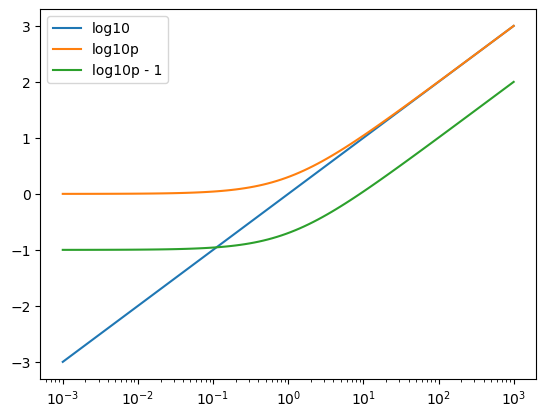

In [10]:
fig = plt.figure()
ax = plt.gca()

x = np.logspace(-3, 3, 100)
log10 = np.log10(x)
log10p = np.log10(1 + x)
log10p2 = np.log10(1 + x) - 1

ax.plot(
    x,
    log10,
    label="log10",
)
ax.plot(
    x,
    log10p,
    label="log10p",
)
ax.plot(
    x,
    log10p2,
    label="log10p - 1",
)

ax.legend()

ax.set_xscale("log")

### Overview Normalized 2D Histogram

In [11]:
def get_bins(x, n_bins=config["bins"]):
    # Get density bins
    bins = np.linspace(
        np.nanpercentile(x, config["min_bin_percentile"]),
        np.nanpercentile(x, 100 - config["min_bin_percentile"]),
        n_bins + 1,
    )
    return bins


density_bins = df_all.groupby("vectorizer")["density"].apply(get_bins).to_dict()
cpy_bins = get_bins(
    df_all["log_cpy"], n_bins=17
)  # The n_bins=17 is to ensure we don't accidentally flip axes

In [12]:
def custom_histplot(data, x, y, normed=True, *args, **kwargs):

    # Get the appropriate facets
    vectorizer = data["vectorizer"].unique()[0]
    field = data["fields_of_study_0"].unique()[0]

    density_bins = get_bins(data[x])

    if normed:
        hist2d, _, _ = np.histogram2d(data[x], data[y], bins=(density_bins, cpy_bins))
        density_hist, _ = np.histogram(data[x], bins=density_bins)
        hist2d_normed = hist2d / density_hist.reshape(1, -1).T

        # Plot the data
        plt.pcolormesh(
            density_bins,
            cpy_bins,
            hist2d_normed.T,
            shading="auto",
            cmap="viridis",
        )
    else:
        sns.histplot(data, x=x, y=y, bins=(density_bins, cpy_bins), *args, **kwargs)

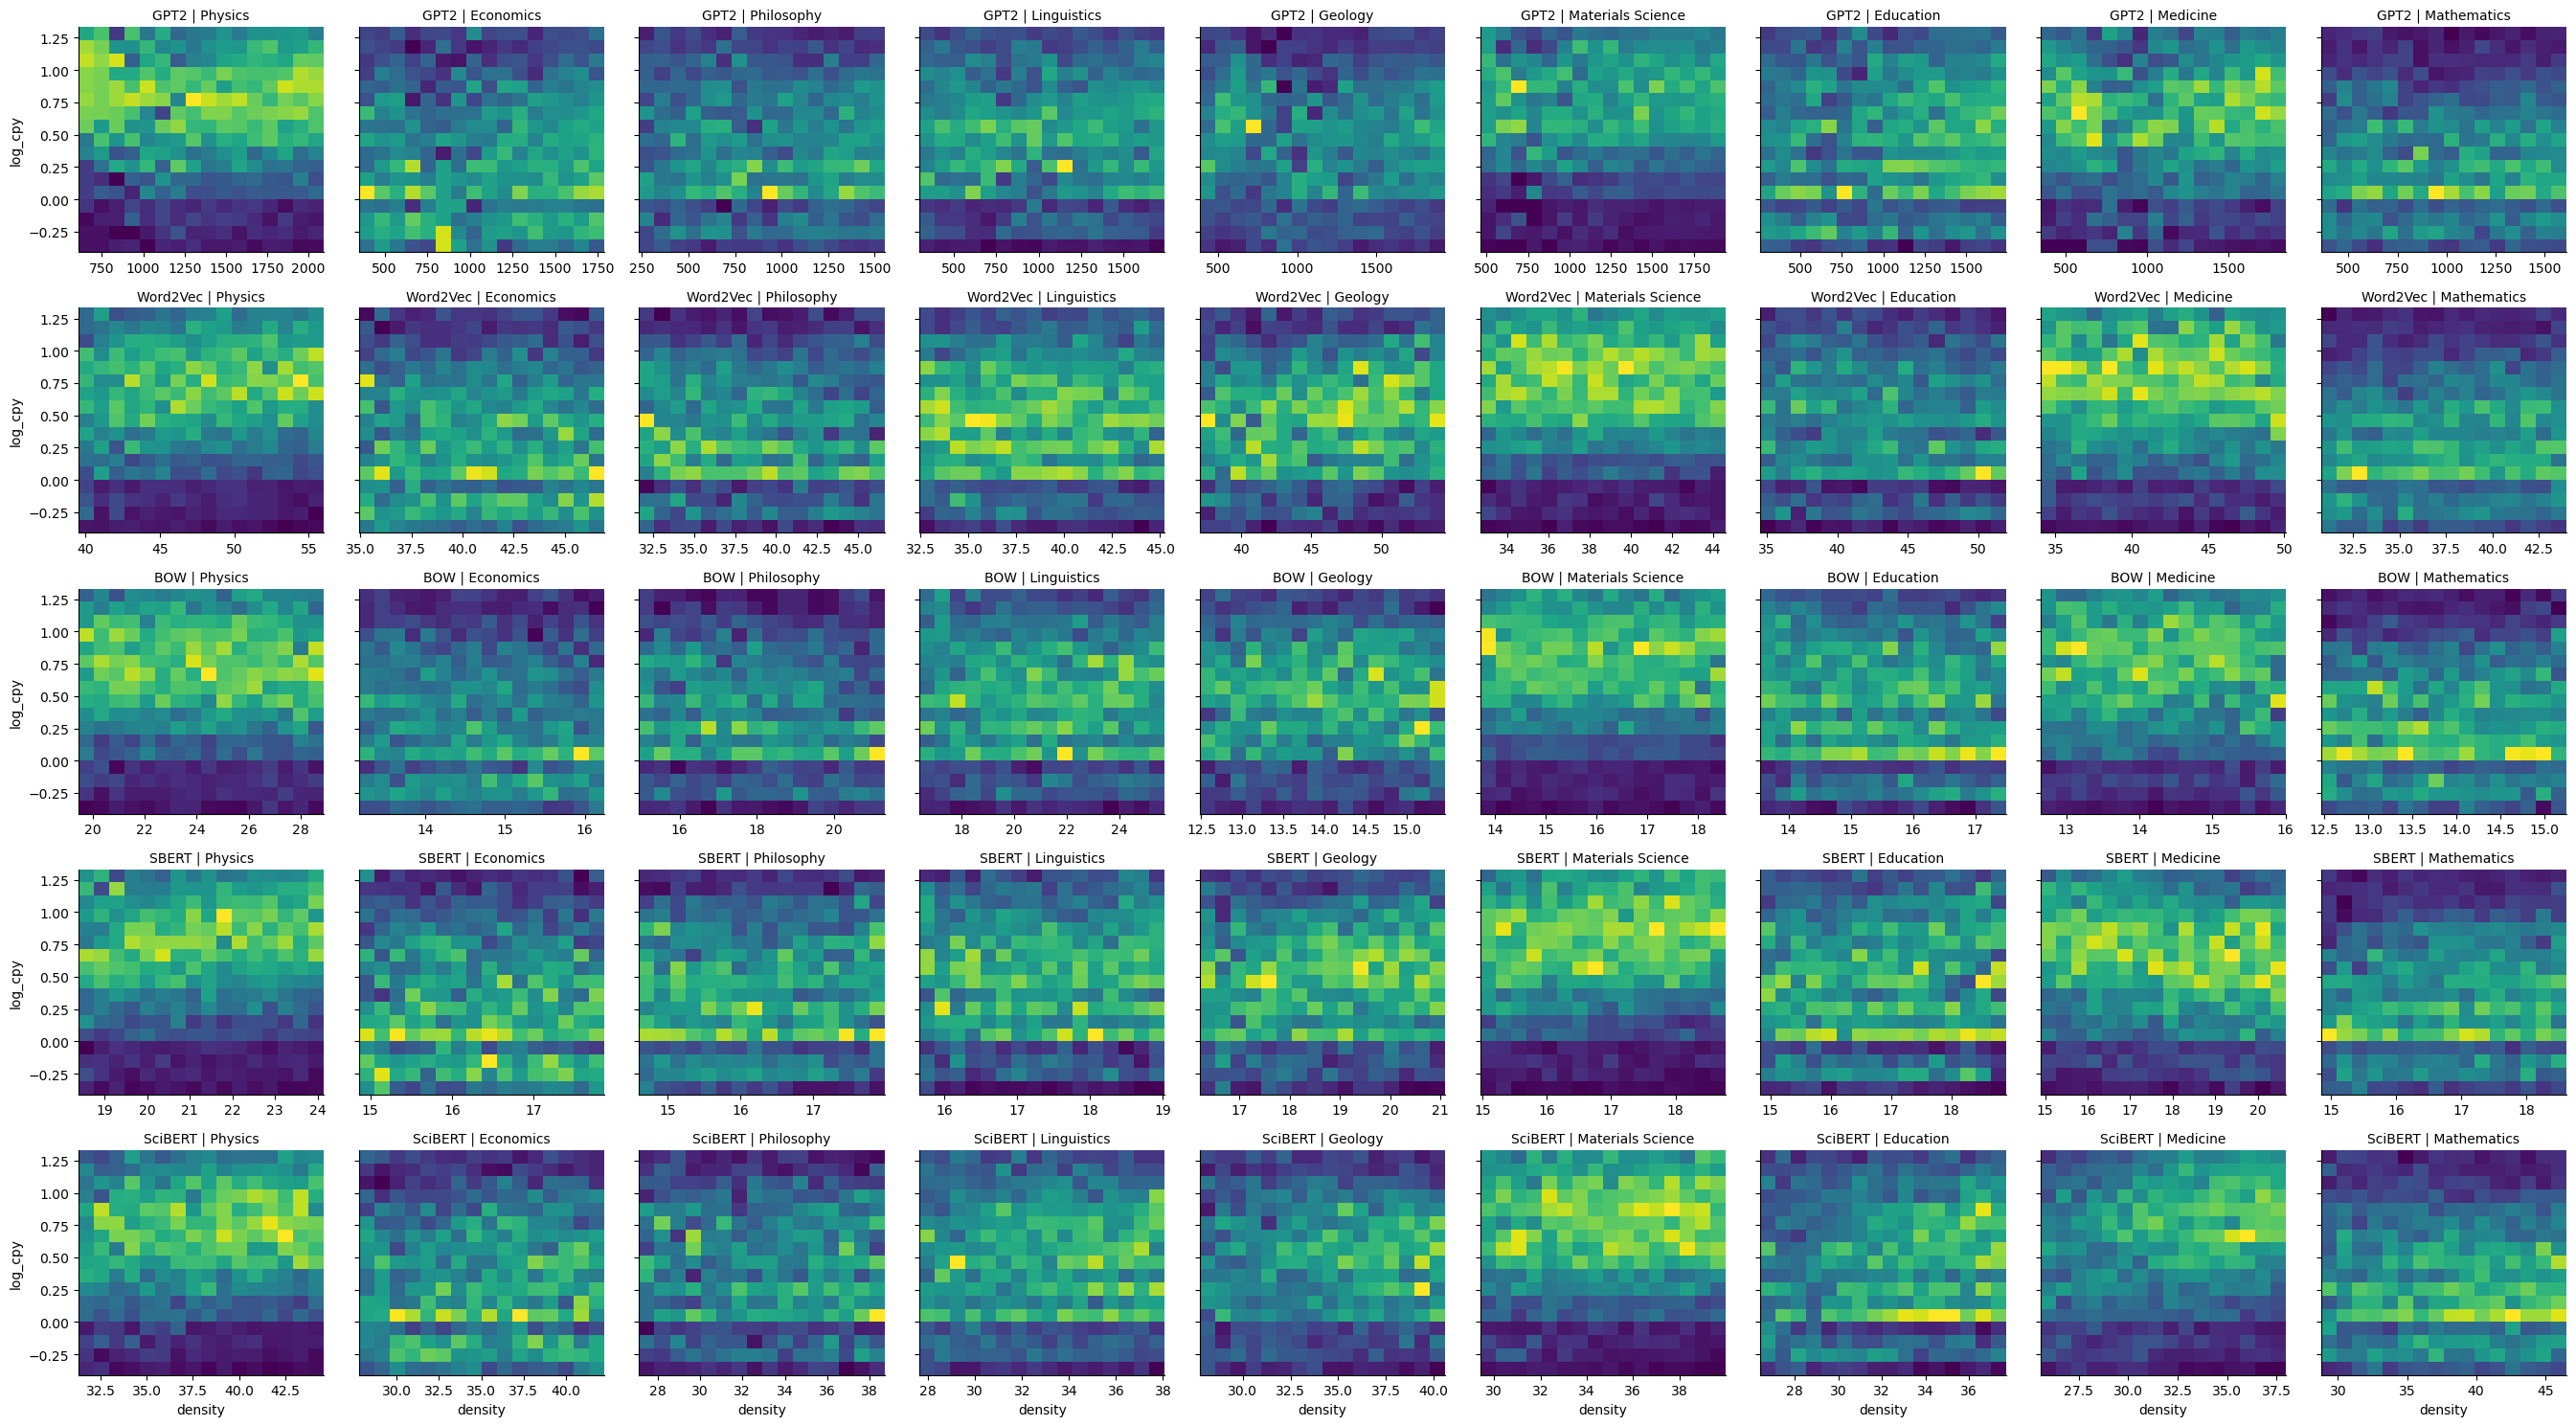

In [13]:
fg = sns.FacetGrid(data=df_all, row="vectorizer", col="fields_of_study_0", sharex=False)
fg.map_dataframe(custom_histplot, x="density", y="log_cpy", normed=True)
fg.set_titles("{row_name} | {col_name}")

### Focused Normalized Histogram

In [14]:
df = df_all.query("vectorizer in ['SciBERT', 'Word2Vec']")

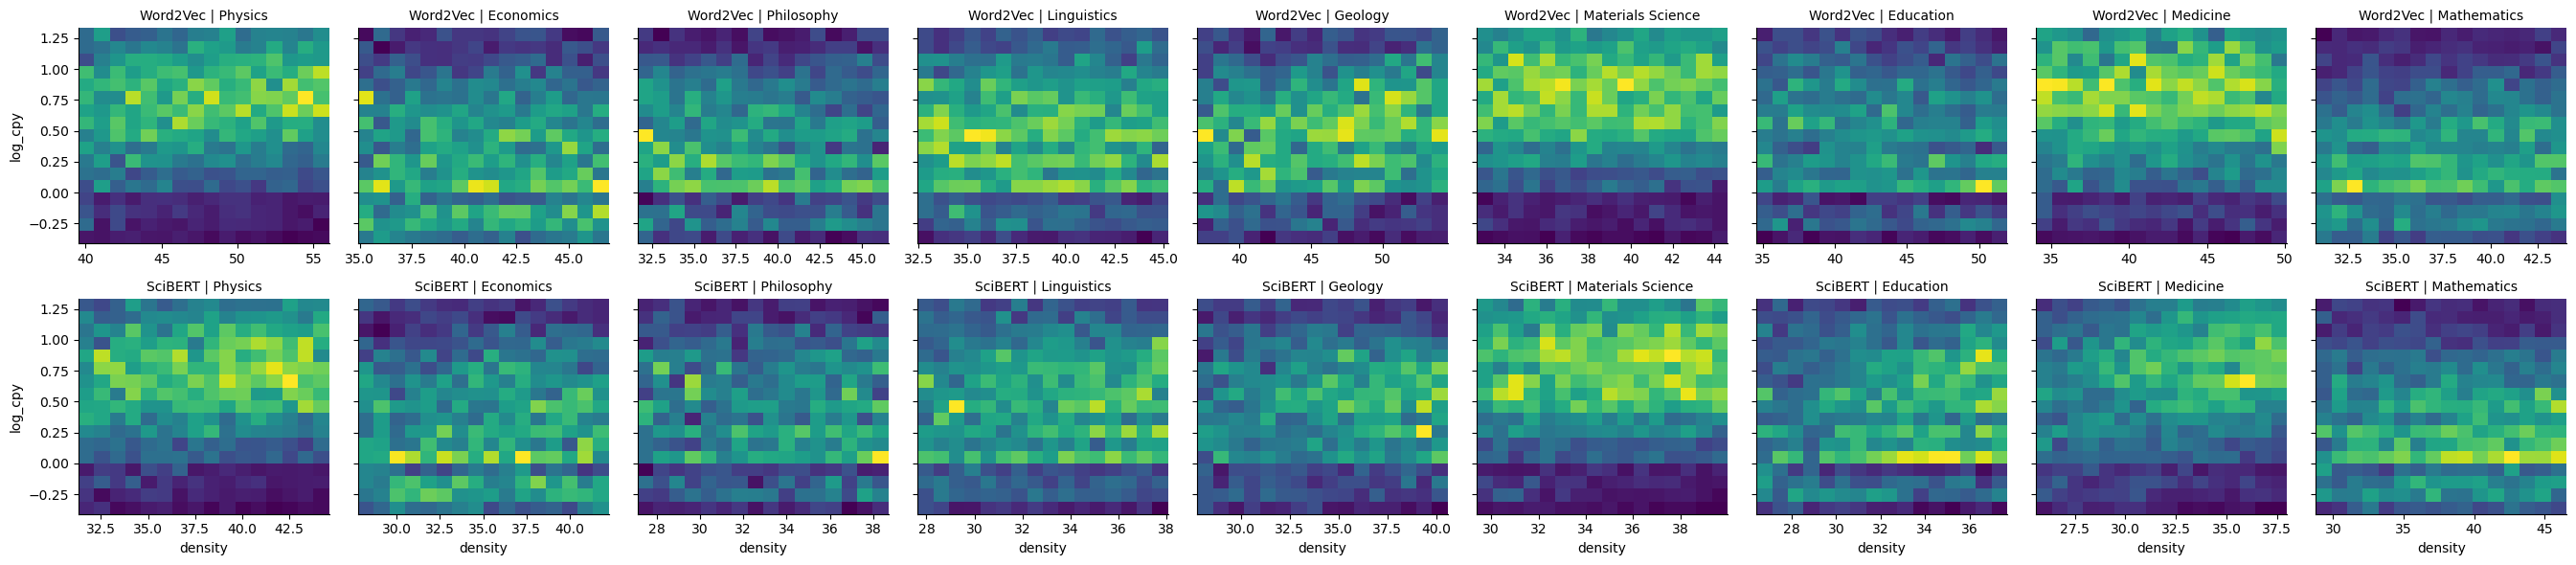

In [15]:
fg = sns.FacetGrid(data=df, row="vectorizer", col="fields_of_study_0", sharex=False)
fg.map_dataframe(custom_histplot, x="density", y="log_cpy", normed=True)
fg.set_titles("{row_name} | {col_name}")

# Statistical Modeling

Note to future self: cmdstanpy and cmdstan advertise conda as *the* way to install.
Don't listen to them.
I couldn't get it to compile when I used conda for anything cmdstanpy related.
I downloaded the repo and compiled manually, and used pip for cmdstanpy.

## Train-Test Split

In [16]:
# Pivot to wide format so we can use the same train_test division
# and so we can use multiple densities at once
df_vectorizers = df_all.pivot_table(
    index="identifier", columns="vectorizer", values="density"
)
# For the nonden cols we can take the first because the other values are duplicates
nonden_cols = [
    "log_cpy",
] + config["nonden_fit_cols"]
df_others = df_all.groupby("identifier")[nonden_cols].first()
df_eval = pd.concat([df_others, df_vectorizers], axis="columns")
df_eval

,log_cpy,references,year,BOW,GPT2,SBERT,SciBERT,Word2Vec
identifier,,,,,,,,
000018fc6887cfb1fe43024b111cbfb4e21bac86,0.816610,153,2011,20.247480,NaN,NaN,40.709152,48.709426
00012cd6c267ec07566e9298ad5d689462133f98,-0.176091,81,2014,16.675367,1821.844826,17.195921,44.223053,46.829885
00015dd1433923dfaecd815a5610b7e02a240bf1,-1.176091,5,2005,NaN,NaN,15.303556,NaN,NaN
0001915f25724aabd56021ad216db4657b544bec,0.449093,15,2004,15.214642,1474.294829,15.101694,38.331719,36.408183
00019656527337df9943eb8fd5fe10035c216630,0.896251,38,2012,NaN,1824.667374,19.787877,NaN,NaN
...,...,...,...,...,...,...,...,...
fffd040a476ea5d68014a0c2d29c132bcfa5c281,0.753328,39,2014,16.932139,1357.686408,15.175140,34.163358,42.351464
fffdae38cfe952ec7fc4da420d8ad26a06384d9f,-0.447158,21,2006,NaN,NaN,17.679814,NaN,NaN
ffff5e6feb617a8cbc7867f2ef0d3422e6107697,0.946125,43,2002,13.273726,1656.083989,15.323810,29.493443,39.875730


In [17]:
# Drop all columns where log_cpy is na
df_eval = df_eval.dropna(subset="log_cpy")

In [18]:
# Apply scaling (normalization by mean and sigma) to help with modelling
df_eval = df_eval.apply(scale)
df_eval

,log_cpy,references,year,BOW,GPT2,SBERT,SciBERT,Word2Vec
identifier,,,,,,,,
000018fc6887cfb1fe43024b111cbfb4e21bac86,0.443906,1.294274,-0.059374,0.851130,NaN,NaN,0.994016,1.026570
00012cd6c267ec07566e9298ad5d689462133f98,-1.024292,0.360432,0.520713,-0.029242,1.027300,-0.092462,1.589500,0.758595
00015dd1433923dfaecd815a5610b7e02a240bf1,-2.503285,-0.625290,-1.219548,NaN,NaN,-0.493021,NaN,NaN
0001915f25724aabd56021ad216db4657b544bec,-0.099649,-0.495589,-1.412910,-0.389248,0.418554,-0.535749,0.591124,-0.727279
00019656527337df9943eb8fd5fe10035c216630,0.561694,-0.197279,0.133988,NaN,1.032243,0.456179,NaN,NaN
...,...,...,...,...,...,...,...,...
fffcfbd21e584fa023c51f2b5b813c8914a7659a,0.591575,-0.430739,-0.639461,NaN,NaN,-0.172983,NaN,NaN
fffd040a476ea5d68014a0c2d29c132bcfa5c281,0.350312,-0.184309,0.520713,0.034041,0.214311,-0.520202,-0.115268,0.120084
fffdae38cfe952ec7fc4da420d8ad26a06384d9f,-1.425198,-0.417769,-1.026186,NaN,NaN,0.009964,NaN,NaN


In [19]:
# Downsample
if config["eval_sample_size"] is not None:
    df_eval = df_eval.sample(config["eval_sample_size"])

In [20]:
# Train-test split
df_train, df_test = train_test_split(df_eval)

In [21]:
# dictionary to store results in
results_dict = {}

## Base model
The base model is just a normal distribution.

In [22]:
stan_model = "base"

In [23]:
# Dict for storing output
output = {}

In [24]:
# Drop na
df_train_i = df_train.dropna(subset=["log_cpy"])
df_test_i = df_train.dropna(subset=["log_cpy"])

In [25]:
# Format data
data = {
    "N": len(df_train_i),
    "y": df_train_i["log_cpy"].values,
    "N_test": len(df_test_i),
    "y_test": df_test_i["log_cpy"].values,
}

In [26]:
# Compile model
model = cmdstanpy.CmdStanModel(stan_file=f"../stan_models/{stan_model}.stan")

In [27]:
# Fit model
fit = model.sample(
    data=data,
)

18:03:45 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:03:51 - cmdstanpy - INFO - CmdStan done processing.


In [28]:
# Parse output
draws = fit.draws_pd()

In [29]:
# Store parameters
output["alpha"] = draws["alpha"].median()
output["sigma"] = draws["sigma"].median()

In [30]:
# Calculate log posterior predictive density
output["log_ppd"] = log_ppd(draws["log_p"])

In [31]:
results_dict[stan_model] = pd.Series(output)

## Linear regression on density
$(c \sim \rho_t)$ vs $(c \sim \rho_v)$

In [32]:
stan_model = "reg"

### Fit

In [33]:
# Dictionary to hold modeling output

# Loop through vectorizers
outputs_for_this_model = {}
for i, vectorizer_i in enumerate(vectorizer_names):
    output = {}

    # Drop na
    df_train_i = df_train.dropna(subset=[vectorizer_i, "log_cpy"])
    df_test_i = df_train.dropna(subset=[vectorizer_i, "log_cpy"])

    # Format data
    data = {
        "N": len(df_train_i),
        "x": df_train_i[vectorizer_i].values,
        "y": df_train_i["log_cpy"].values,
        "N_test": len(df_test_i),
        "x_test": df_test_i[vectorizer_i].values,
        "y_test": df_test_i["log_cpy"].values,
    }

    # Compile model
    model = cmdstanpy.CmdStanModel(stan_file=f"../stan_models/{stan_model}.stan")

    # Fit model
    fit = model.sample(
        data=data,
    )

    # Parse output
    draws = fit.draws_pd()

    # Store parameters
    output["alpha"] = draws["alpha"].median()
    output[f"beta[{vectorizer_i}]"] = draws["beta"].median()
    output["sigma"] = draws["sigma"].median()

    # Calculate log posterior predictive density
    output["log_ppd"] = log_ppd(draws["log_p"])

    key = f"{stan_model}_{vectorizer_i}"
    outputs_for_this_model[key] = output
    results_dict[key] = output

18:03:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:04:56 - cmdstanpy - INFO - CmdStan done processing.
18:04:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
	Exception: normal_lpdf: Scale parameter is 0, but must be pos

18:04:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:06:07 - cmdstanpy - INFO - CmdStan done processing.
18:06:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
	Exception: normal_lpdf: Scale parameter is 0, but must be pos

18:06:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:07:13 - cmdstanpy - INFO - CmdStan done processing.
18:07:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
Exception: normal_lpdf: Scale parameter is 0, but must be pos

18:07:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:08:22 - cmdstanpy - INFO - CmdStan done processing.
18:08:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
	Exception: normal_lpdf: Scale parameter is 0, but must be pos

18:08:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:09:37 - cmdstanpy - INFO - CmdStan done processing.
18:09:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
Consider re-running with show_console=True if the above output is unclear!


### Evaluate

In [34]:
# Format for showing here
output = pd.DataFrame(outputs_for_this_model).T
output["vectorizer"] = vectorizer_names

In [35]:
def medianplot(data, x, y, bins, ax):

    x = data[x]
    y = data[y]

    centers = (bins[1:] + bins[:-1]) / 2

    # Calculate running median
    median, bin_edges, bin_number = binned_statistic(
        x, y, statistic=np.nanmedian, bins=bins
    )
    ax.plot(
        centers,
        median,
        color="k",
    )

    # Calculate running percentiles
    low, bin_edges, bin_number = binned_statistic(
        x,
        y,
        statistic=lambda v: np.nanpercentile(v, 16),
        bins=bins,
    )
    high, bin_edges, bin_number = binned_statistic(
        x,
        y,
        statistic=lambda v: np.nanpercentile(v, 84),
        bins=bins,
    )
    ax.fill_between(
        centers,
        low,
        high,
        color="k",
        alpha=0.1,
    )

    ax.set_xlim(bins[0], bins[-1])

In [36]:
left_edge = np.nanpercentile(
    df_eval[vectorizer_names].values.flatten(), config["min_bin_percentile"]
)
right_edge = -left_edge
bins = np.linspace(left_edge, right_edge, config["bins"])

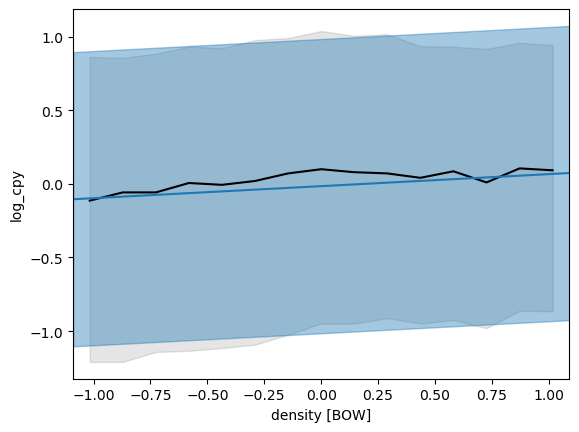

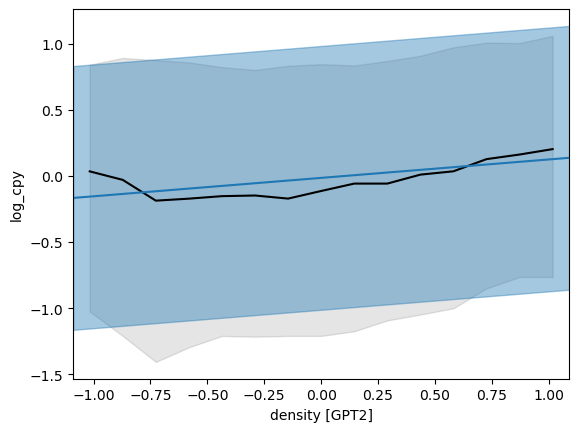

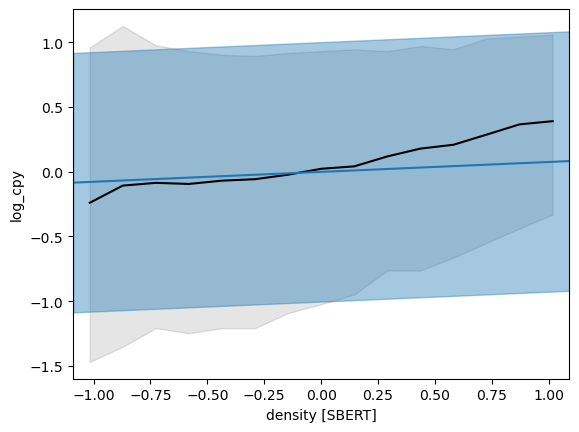

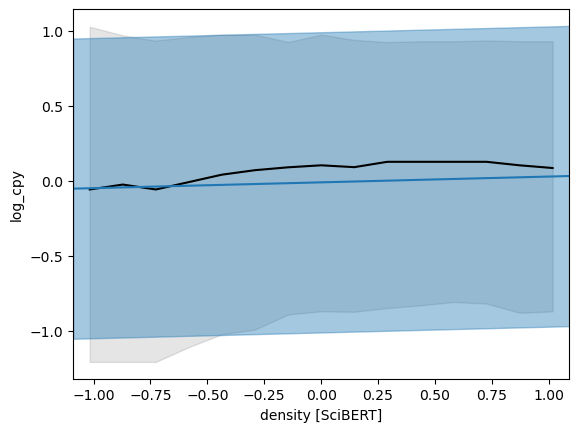

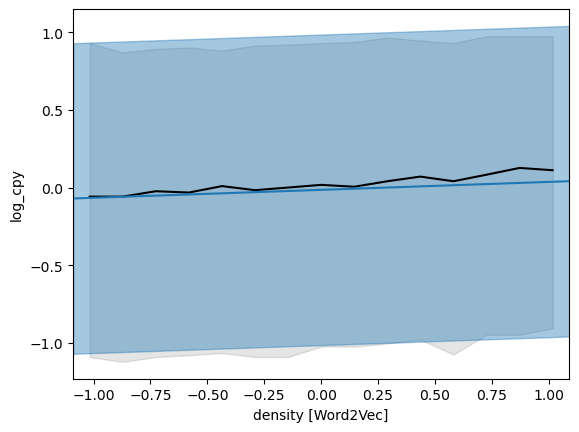

In [37]:
for i, row in output.iterrows():
    fig = plt.figure()
    ax = plt.gca()

    medianplot(
        data=df_eval,
        x=row["vectorizer"],
        y="log_cpy",
        bins=bins,
        ax=ax,
    )

    # Plot the regression
    xs = bins
    ys = row["alpha"] + row[f"beta[{row["vectorizer"]}]"] * xs
    ax.plot(
        xs,
        ys,
        color=palette[0],
    )
    ax.fill_between(
        xs,
        ys - row["sigma"],
        ys + row["sigma"],
        color=palette[0],
        alpha=0.4,
    )

    ax.set_xlabel(f"density [{row["vectorizer"]}]")
    ax.set_ylabel("log_cpy")

    

## Multivariate linear regression w/o density
The next model is a multivate linear regression with no density

In [38]:
stan_model = "multireg"
fit_cols = config["nonden_fit_cols"]
cols = [
    "log_cpy",
] + fit_cols

In [39]:
# Dict for storing output
output = {}

In [40]:
# Drop na
df_train_i = df_train[cols].dropna()
df_test_i = df_train[cols].dropna()

In [41]:
# Format data
data = {
    "N": len(df_train_i),
    "K": len(fit_cols),
    "x": df_train_i[fit_cols].values,
    "y": df_train_i["log_cpy"].values,
    "N_test": len(df_test_i),
    "x_test": df_test_i[fit_cols].values,
    "y_test": df_test_i["log_cpy"].values,
}

In [42]:
# Compile model
model = cmdstanpy.CmdStanModel(stan_file=f"../stan_models/{stan_model}.stan")

In [43]:
# Fit model
fit = model.sample(
    data=data,
)

18:09:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:11:53 - cmdstanpy - INFO - CmdStan done processing.
18:11:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
Exception: normal_lpdf: Sc

In [44]:
# Parse output
draws = fit.draws_pd()

In [45]:
# Store parameters
output["alpha"] = draws["alpha"].median()
output["sigma"] = draws["sigma"].median()
beta_cols = [col for col in draws.columns if col[:4] == "beta"]
betas = draws[beta_cols].median(axis="rows")
for i, fit_col in enumerate(fit_cols):
    output[f"beta[{fit_col}]"] = betas.iloc[i]

In [46]:
# Calculate log posterior predictive density
output["log_ppd"] = log_ppd(draws["log_p"])

In [47]:
results_dict[stan_model] = pd.Series(output)

## Multivariate linear regression
Now with density.

In [48]:
stan_model = "multireg"

In [49]:
# Dictionary to hold modeling output

# Loop through vectorizers
outputs_for_this_model = {}
for i, vectorizer_i in enumerate(vectorizer_names):
    output = {}

    # Drop na
    fit_cols = [
        vectorizer_i,
    ] + config["nonden_fit_cols"]
    cols = [
        "log_cpy",
    ] + fit_cols
    df_train_i = df_train.dropna(subset=cols)
    df_test_i = df_train.dropna(subset=cols)

    # Format data
    data = {
        "N": len(df_train_i),
        "K": len(fit_cols),
        "x": df_train_i[fit_cols].values,
        "y": df_train_i["log_cpy"].values,
        "N_test": len(df_test_i),
        "x_test": df_test_i[fit_cols].values,
        "y_test": df_test_i["log_cpy"].values,
    }

    # Compile model
    model = cmdstanpy.CmdStanModel(stan_file=f"../stan_models/{stan_model}.stan")

    # Fit model
    fit = model.sample(
        data=data,
    )

    # Parse output
    draws = fit.draws_pd()

    # Store parameters
    output["alpha"] = draws["alpha"].median()
    output["sigma"] = draws["sigma"].median()
    beta_cols = [col for col in draws.columns if col[:4] == "beta"]
    betas = draws[beta_cols].median(axis="rows")
    for i, fit_col in enumerate(fit_cols):
        output[f"beta[{fit_col}]"] = betas.iloc[i]

    # Calculate log posterior predictive density
    output["log_ppd"] = log_ppd(draws["log_p"])

    key = f"{stan_model}_{vectorizer_i}"
    outputs_for_this_model[key] = output
    results_dict[key] = output

18:11:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:13:34 - cmdstanpy - INFO - CmdStan done processing.
18:13:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
Consider re-running with show_console=True if the above output is unclear!


18:13:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:16:30 - cmdstanpy - INFO - CmdStan done processing.
18:16:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
Exception: normal_lpdf: Sc

18:16:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:00 - cmdstanpy - INFO - CmdStan done processing.
18:18:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
Consider re-running with show_console=True if the above output is unclear!


18:18:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:23 - cmdstanpy - INFO - CmdStan done processing.
18:19:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
	Exception: normal_lpdf: Sc

18:19:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:47 - cmdstanpy - INFO - CmdStan done processing.
18:20:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
	Exception: normal_lpdf: Sc

## Multivariate linear regression w/ all fields
The next model is a multivate linear regression using every variable we have

In [50]:
stan_model = "multireg"
fit_cols = config["nonden_fit_cols"] + vectorizer_names
cols = [
    "log_cpy",
] + fit_cols

In [51]:
# Dict for storing output
output = {}

In [52]:
# Drop na
df_train_i = df_train[cols].dropna()
df_test_i = df_train[cols].dropna()

In [53]:
# Format data
data = {
    "N": len(df_train_i),
    "K": len(fit_cols),
    "x": df_train_i[fit_cols].values,
    "y": df_train_i["log_cpy"].values,
    "N_test": len(df_test_i),
    "x_test": df_test_i[fit_cols].values,
    "y_test": df_test_i["log_cpy"].values,
}

In [54]:
# Compile model
model = cmdstanpy.CmdStanModel(stan_file=f"../stan_models/{stan_model}.stan")

In [55]:
# Fit model
fit = model.sample(
    data=data,
)

18:20:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:42 - cmdstanpy - INFO - CmdStan done processing.
18:21:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
Exception: normal_lpdf: Sca

In [56]:
# Parse output
draws = fit.draws_pd()

In [57]:
# Store parameters
output["alpha"] = draws["alpha"].median()
output["sigma"] = draws["sigma"].median()
beta_cols = [col for col in draws.columns if col[:4] == "beta"]
betas = draws[beta_cols].median(axis="rows")
for i, fit_col in enumerate(fit_cols):
    output[f"beta[{fit_col}]"] = betas.iloc[i]

In [58]:
# Calculate log posterior predictive density
output["log_ppd"] = log_ppd(draws["log_p"])

In [59]:
results_dict[f"full_{stan_model}"] = pd.Series(output)

# Summarize

In [60]:
results = pd.DataFrame(results_dict).T
results

,alpha,beta[BOW],beta[GPT2],beta[SBERT],beta[SciBERT],beta[Word2Vec],beta[references],beta[year],log_ppd,sigma
base,-0.001129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-149901.728386,1.000560
reg_BOW,-0.015747,0.081607,NaN,NaN,NaN,NaN,NaN,NaN,-105732.349970,0.998851
reg_GPT2,-0.015029,NaN,0.139124,NaN,NaN,NaN,NaN,NaN,-105873.445074,0.996271
reg_SBERT,-0.001652,NaN,NaN,0.076441,NaN,NaN,NaN,NaN,-105720.882488,1.001960
reg_SciBERT,-0.010497,NaN,NaN,NaN,0.038645,NaN,NaN,NaN,-104391.293867,1.001940
reg_Word2Vec,-0.014629,NaN,NaN,NaN,NaN,0.051171,NaN,NaN,-105671.096211,1.000410
multireg,-0.000964,NaN,NaN,NaN,NaN,NaN,0.127466,0.126912,-147946.725946,0.981659
multireg_BOW,-0.012876,0.064070,NaN,NaN,NaN,NaN,0.154342,0.133038,-104185.288143,0.977551
multireg_GPT2,-0.013148,NaN,0.123469,NaN,NaN,NaN,0.112824,0.113880,-104758.705572,0.981039
multireg_SBERT,-0.001640,NaN,NaN,0.057554,NaN,NaN,0.113638,0.116254,-104584.448418,0.986296


## Visualize metrics

### Log Posterior Predictive Density

[Text(0, 0, 'base'),
 Text(1, 0, 'reg_BOW'),
 Text(2, 0, 'reg_GPT2'),
 Text(3, 0, 'reg_SBERT'),
 Text(4, 0, 'reg_SciBERT'),
 Text(5, 0, 'reg_Word2Vec'),
 Text(6, 0, 'multireg'),
 Text(7, 0, 'multireg_BOW'),
 Text(8, 0, 'multireg_GPT2'),
 Text(9, 0, 'multireg_SBERT'),
 Text(10, 0, 'multireg_SciBERT'),
 Text(11, 0, 'multireg_Word2Vec'),
 Text(12, 0, 'full_multireg')]

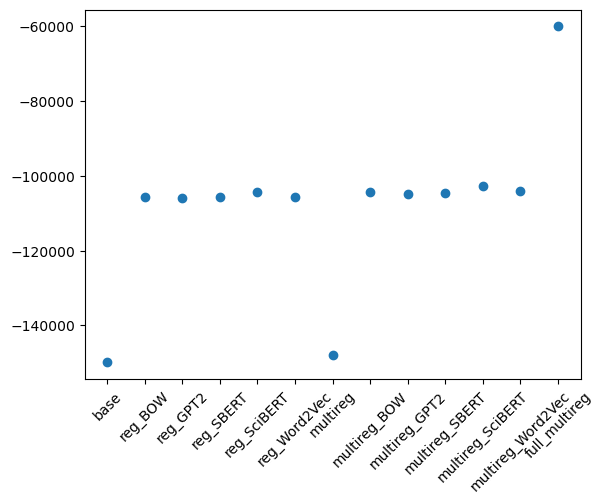

In [61]:
fig = plt.figure()
ax = plt.gca()

x = np.arange(len(results))
ax.scatter(
    x,
    results["log_ppd"],
)

ax.set_xticks(x)
ax.set_xticklabels(results.index, rotation=45)

### RMSE

In [62]:
beta_cols = [col for col in results.columns if col[:4] == "beta"]
betas = results[beta_cols].fillna(0.0)
x_cols = [col[5:-1] for col in beta_cols]
x_test = df_test[x_cols].fillna(0.0)

In [63]:
# Calculate y_pred
y_pred = np.matmul(x_test.values, betas.T)
y_pred += results["alpha"].values.reshape(1, -1)
y_pred.index = df_test.index
y_pred

,base,reg_BOW,reg_GPT2,reg_SBERT,reg_SciBERT,reg_Word2Vec,multireg,multireg_BOW,multireg_GPT2,multireg_SBERT,multireg_SciBERT,multireg_Word2Vec,full_multireg
identifier,,,,,,,,,,,,,
6071c8a07e3626cbe7dc0199147cfe92aabe7ae4,-0.001129,-0.060567,0.075672,-0.055431,-0.017165,-0.071936,0.078876,0.025896,0.139719,0.032471,0.066864,0.058989,0.070408
c7188396767227c0d9ed087a7b077f22fccd7372,-0.001129,0.073412,-0.015029,-0.001652,-0.090512,-0.011323,0.079393,0.139690,0.059083,0.072221,0.036341,0.073635,0.212682
a14bc7b379e9ad9f437d9c9923af3c8db2cd146e,-0.001129,-0.015747,-0.270389,0.015503,-0.010497,-0.014629,-0.156603,-0.184149,-0.378823,-0.130069,-0.181831,-0.187337,-0.354092
79451fec0d9c06e65dd4955389b7a56b222503c6,-0.001129,0.140569,0.024732,-0.030308,-0.029314,-0.023027,-0.085773,0.020352,-0.053917,-0.100814,-0.109522,-0.104329,0.016500
74f2f7ca8ab966f8e9e7608b87d0951e90b3be25,-0.001129,0.085691,-0.015029,-0.001652,0.036919,0.008764,-0.068982,0.001587,-0.074641,-0.064870,-0.052886,-0.076356,-0.088886
...,...,...,...,...,...,...,...,...,...,...,...,...,...
357314fe520c80b746b0875e8821769ba8e49550,-0.001129,-0.015747,-0.015029,-0.035066,-0.010497,-0.014629,0.110288,0.099120,0.087027,0.075808,0.107860,0.103613,0.024237
ef6171fc76e075f0b8f9fdd06fec95d675dd595d,-0.001129,-0.015747,-0.015029,-0.030009,-0.010497,-0.014629,0.156061,0.146565,0.128140,0.121626,0.156691,0.152372,0.078461
934ae897fe1485152e4844e575edebd502634701,-0.001129,-0.015747,-0.015029,-0.027521,-0.010497,-0.014629,0.106723,0.090813,0.084170,0.078912,0.100595,0.095188,0.031163


In [64]:
# Calcualte rmse
results["rmse"] = y_pred.apply(lambda x: root_mean_squared_error(df_test["log_cpy"], x))

(0.0, 0.9994395555239334)

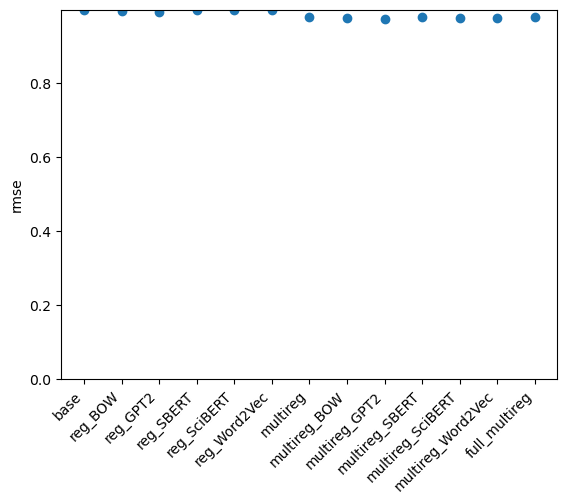

In [65]:
fig = plt.figure()
ax = plt.gca()

x = np.arange(len(results))
ax.scatter(
    x,
    results["rmse"],
)

ax.set_xticks(x)
ax.set_xticklabels(results.index, rotation=45, ha="right")
ax.set_ylabel("rmse")

ax.set_ylim(0, ax.get_ylim()[1])

### Maximum slopes

In [66]:
max_betas = results[beta_cols].max(axis="columns")

(0.0, 0.1640527775)

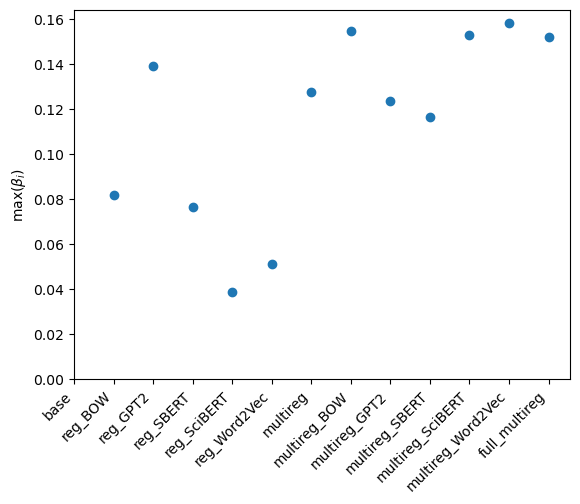

In [67]:
fig = plt.figure()
ax = plt.gca()

x = np.arange(len(results))
ax.scatter(
    x,
    max_betas,
)

ax.set_xticks(x)
ax.set_xticklabels(results.index, rotation=45, ha="right")
ax.set_ylabel(r"max($\beta_i$)")

ax.set_ylim(0, ax.get_ylim()[1])

Text(0, 0.5, '1 - rmse')

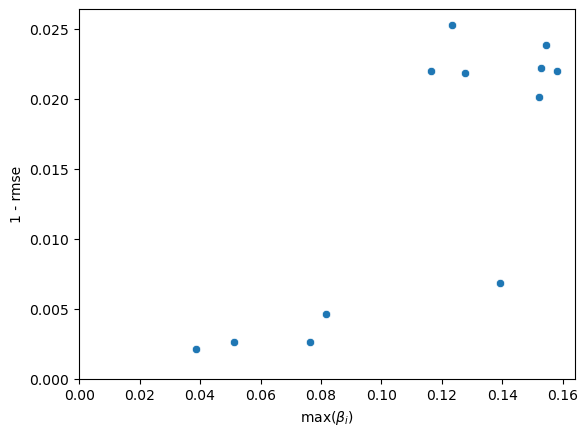

In [68]:
# max slopes correlation with rmse
ax = sns.scatterplot(
    results,
    x=max_betas,
    y=1 - results["rmse"],
)
ax.set_xlim(0, ax.get_xlim()[1])
ax.set_ylim(0, ax.get_ylim()[1])

ax.set_xlabel(r"$\max(\beta_i)$")
ax.set_ylabel(r"1 - rmse")

### RMSE vs distance from center

/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_13375/856283778.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df_test_to_group.groupby(cut_key)
/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_13375/856283778.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mean_y_pred = df_grouped.apply(get_mean_y_pred)
/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_13375/856283778.py:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. Thi

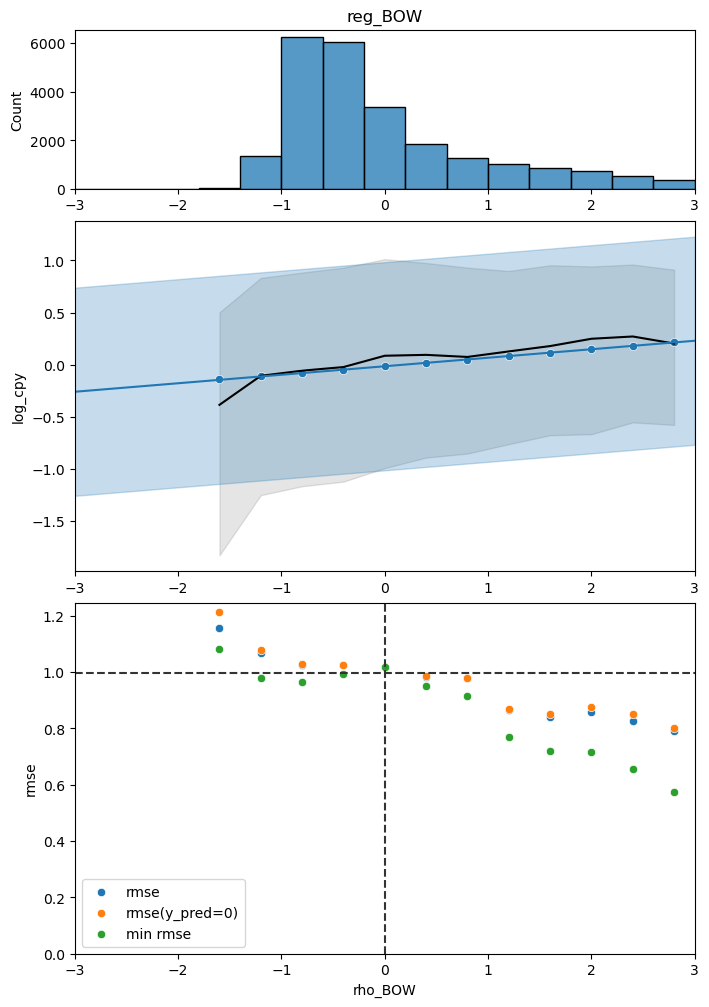

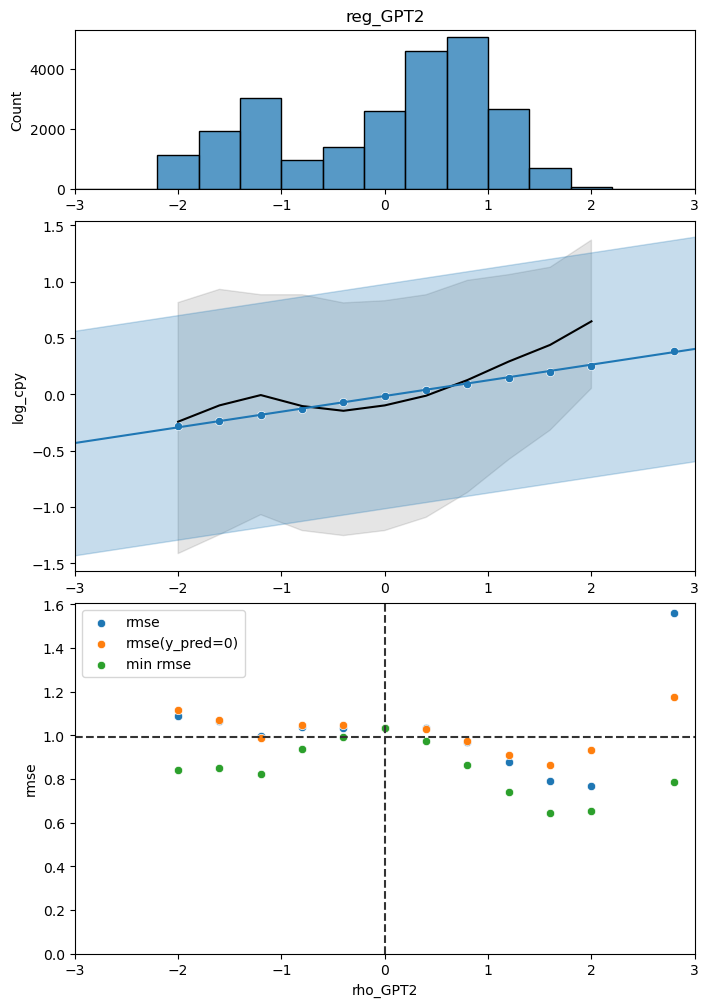

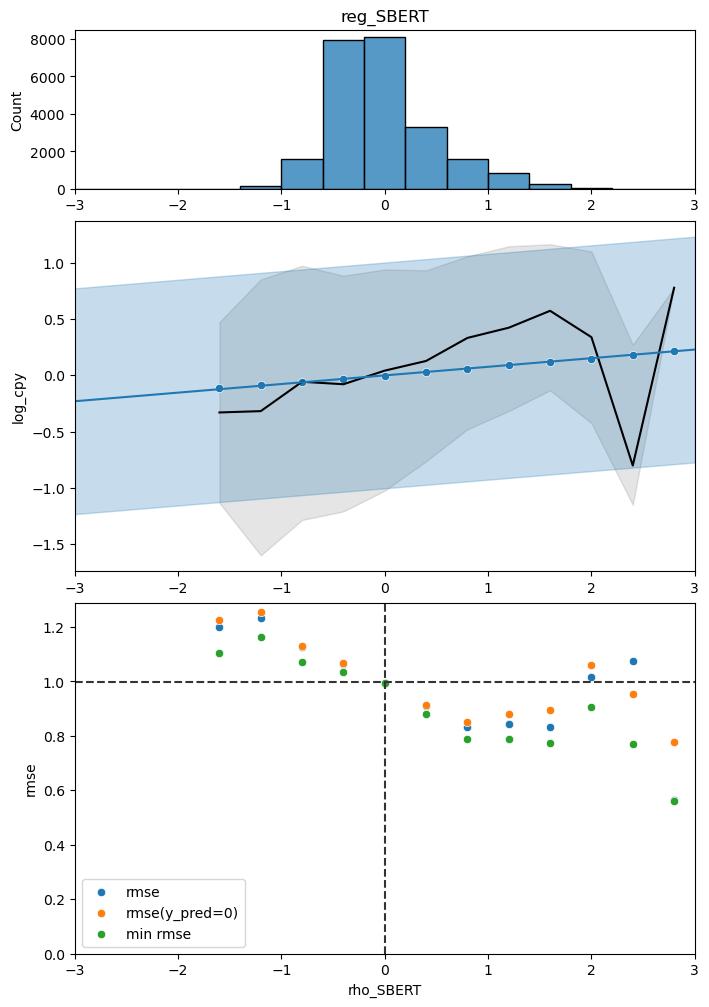

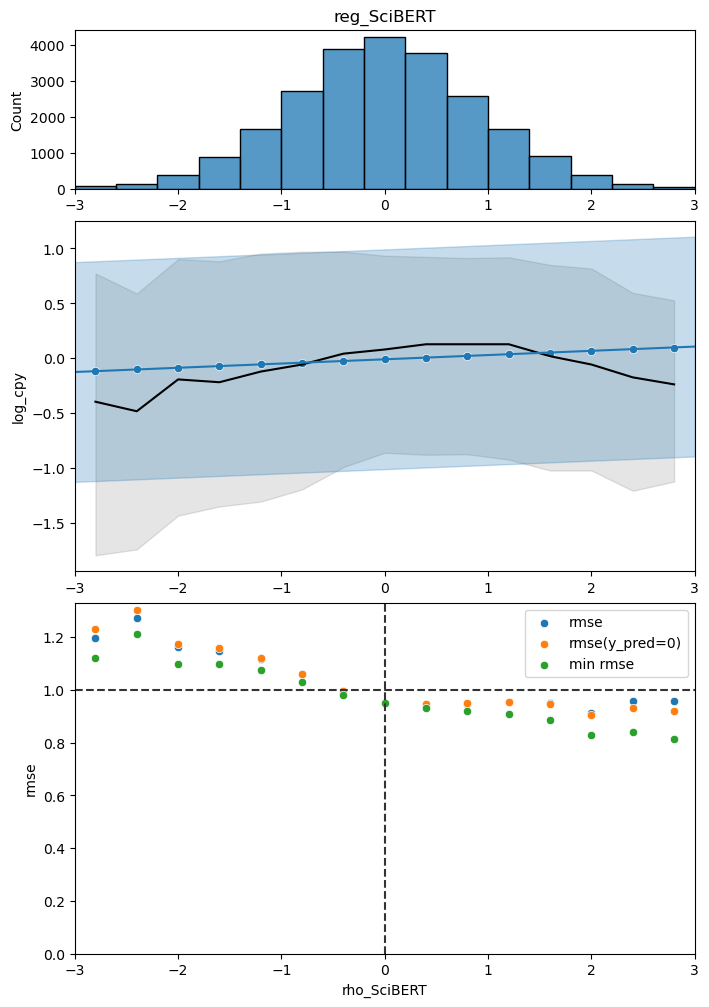

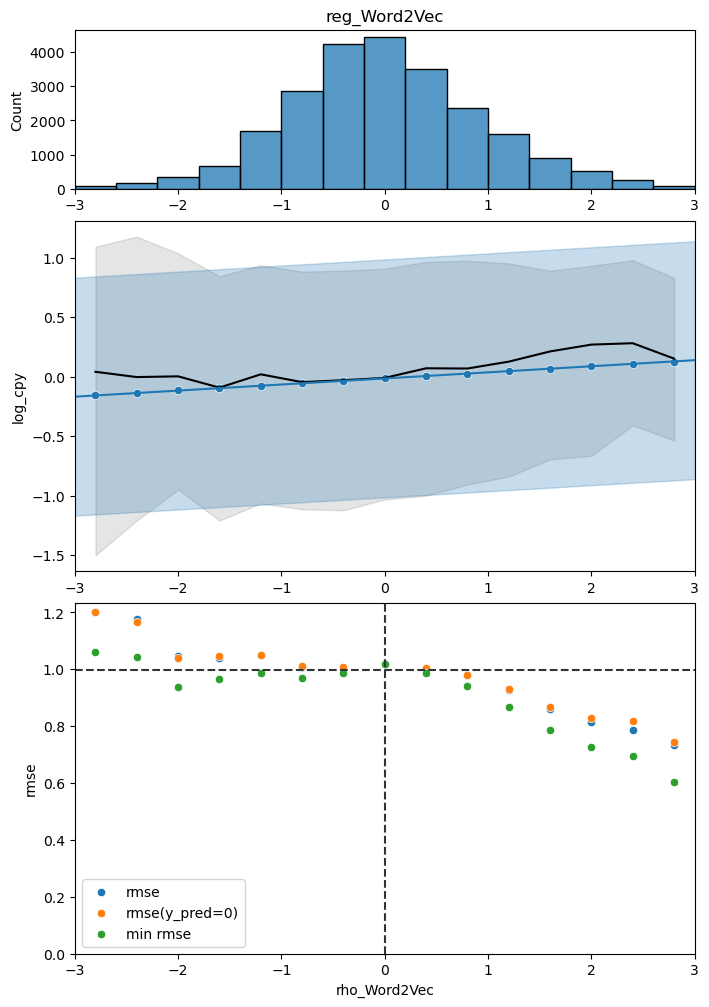

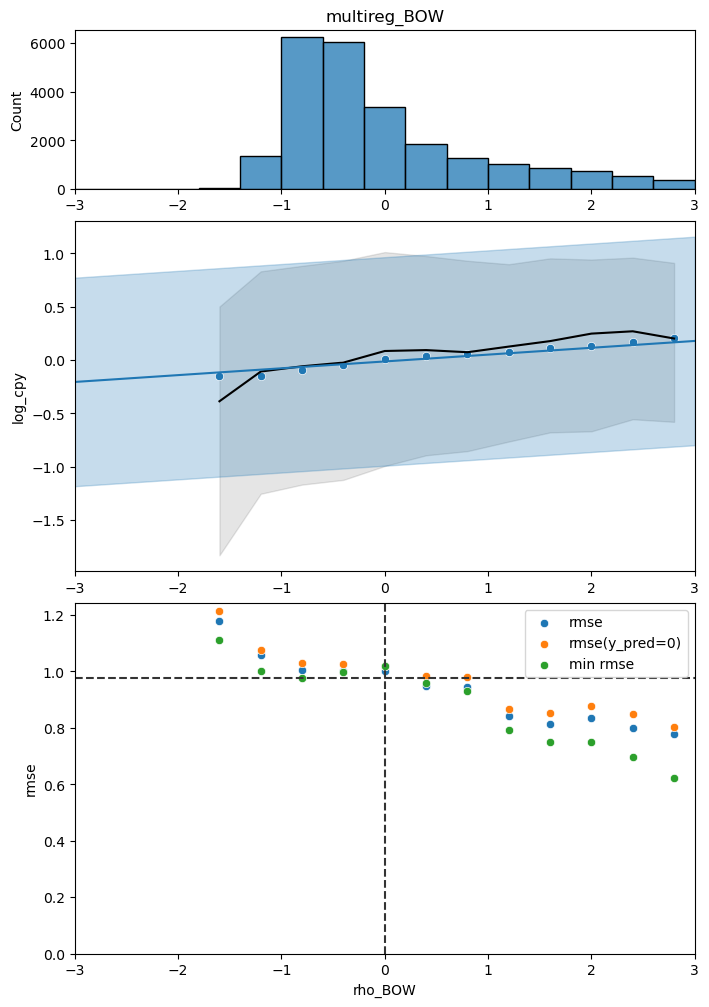

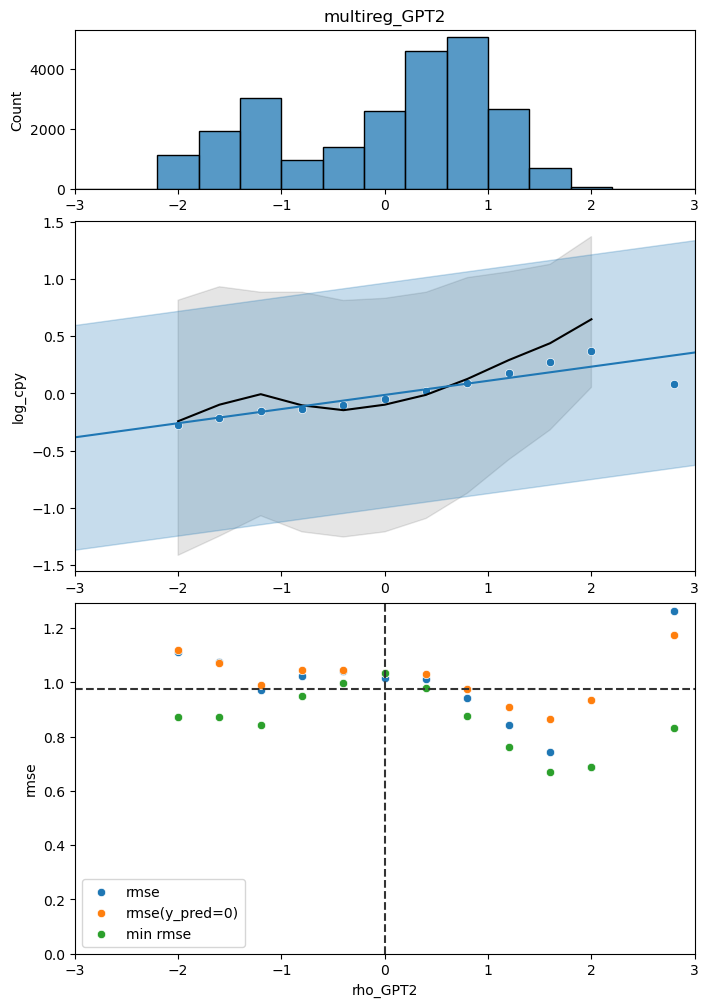

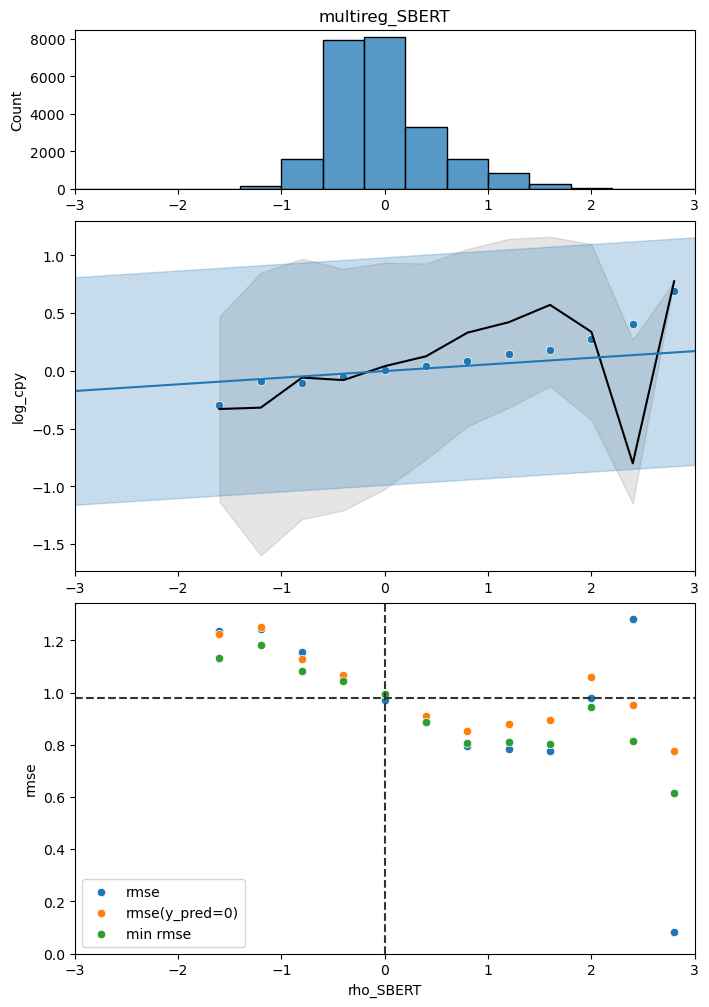

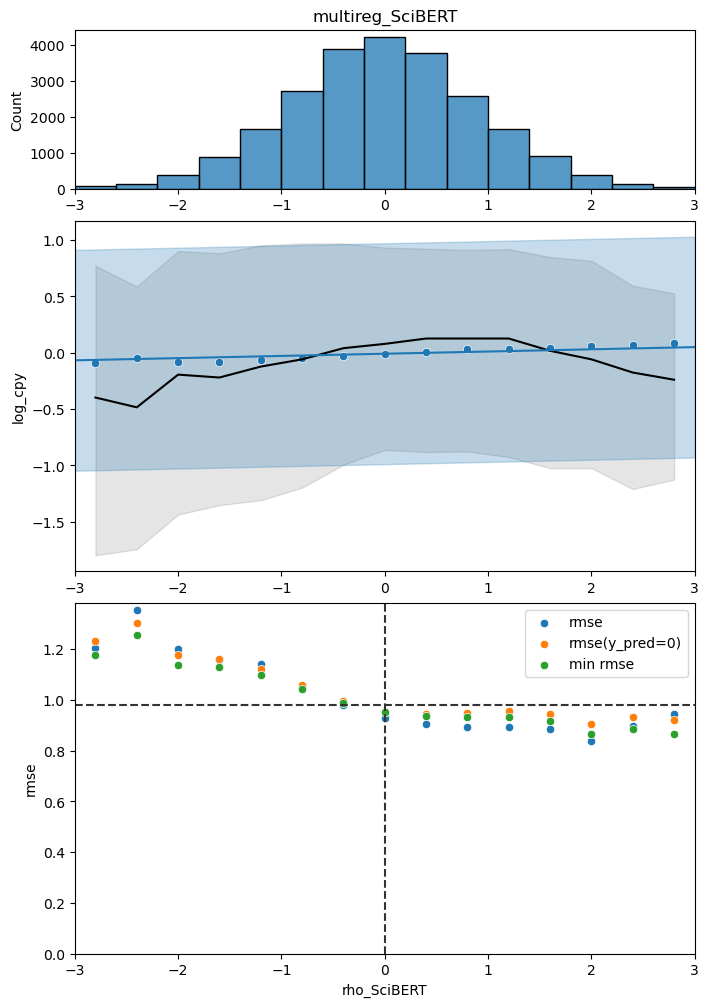

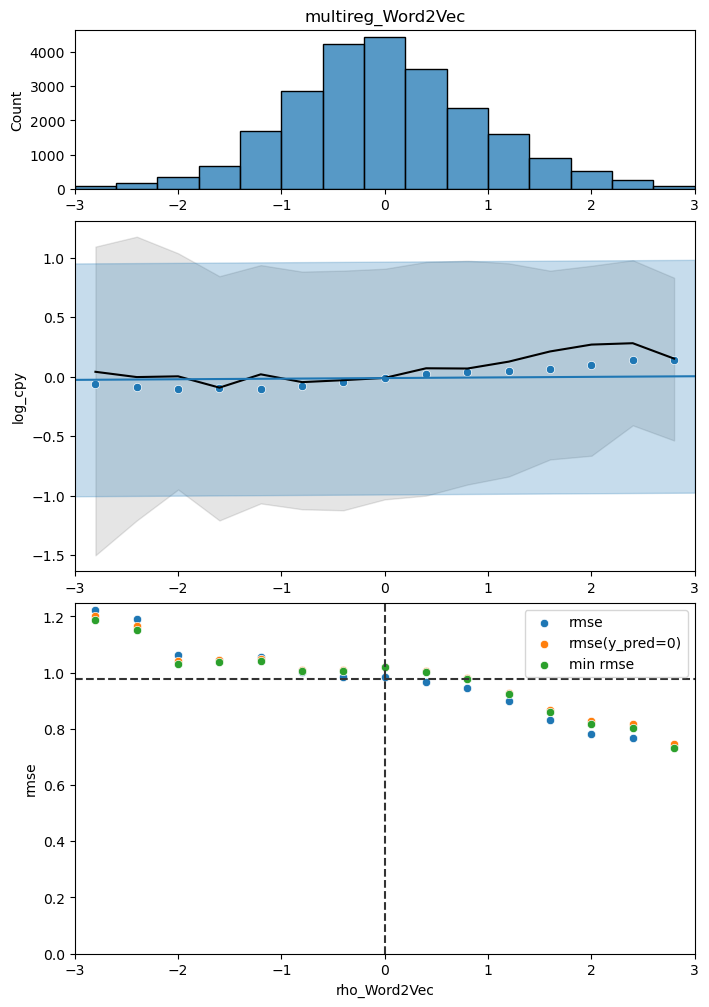

In [78]:
# Inspect rmse as a function of distance from the center
for model_i in results.index:

    row = results.loc[model_i]

    # Only do models that have a density dependence
    try:
        vectorizer_i = model_i.split("_")[-1]
        assert vectorizer_i in vectorizer_names
    except AssertionError:
        continue

    # Bin and labels setup
    bins = np.linspace(-3, 3, config["bins"])
    centers = 0.5 * (bins[:-1] + bins[1:])
    den_key = f"rho_{vectorizer_i}"
    cut_key = f"{den_key}_bin"
    model_key = f"y_pred_{model_i}"

    # Format data into a new df and group it
    df_test_to_group = pd.DataFrame()
    df_test_to_group[den_key] = df_test[vectorizer_i]
    df_test_to_group[model_key] = y_pred[model_i]
    df_test_to_group[cut_key] = pd.cut(df_test_to_group[den_key], bins)
    df_test_to_group["y_test"] = df_test["log_cpy"]
    df_grouped = df_test_to_group.groupby(cut_key)

    # Get mean predicted y per bin
    def get_mean_y_pred(df):
        if len(df) == 0:
            return np.nan
        return df[model_key].mean()
    mean_y_pred = df_grouped.apply(get_mean_y_pred)

    # Get rmse
    def get_rmse_of_df(df):
        if len(df) == 0:
            return np.nan
        return root_mean_squared_error(df["y_test"], df[model_key])
    rmse_per_bin = df_grouped.apply(get_rmse_of_df)

    # Also get rmse if y_pred was just the mean
    def get_rmse_from_mean(df):
        if len(df) == 0:
            return np.nan
        y_pred = np.zeros(len(df)) # Since we normalized to 0
        return root_mean_squared_error(df["y_test"], y_pred)
    rmse_from_mean = df_grouped.apply(get_rmse_from_mean)

    # And rmse expected if it was a straight improvement on the mean that scales with
    # slope
    min_rmse = rmse_from_mean - np.abs(centers * row[f"beta[{vectorizer_i}]"])

    # Plot
    fig, ax_dict = plt.subplot_mosaic(
        [
            [
                "hist",
            ],
            [
                "reg",
            ],
            [
                "reg",
            ],
            [
                "rmse",
            ],
            [
                "rmse",
            ],
        ],
        figsize=(8, 12),
    )

    # Hist plot
    ax = ax_dict["hist"]
    sns.histplot(
        x=df_test_to_group[den_key],
        ax=ax,
        bins=bins,
    )
    ax.set_xlim(bins[0], bins[-1])
    ax.set_title(model_i)
    ax.set_xlabel(None)

    # Regression plot
    ax = ax_dict["reg"]

    # Plot the median
    medianplot(
        data=df_test_to_group,
        x=den_key,
        y="y_test",
        bins=bins,
        ax=ax,
    )

    # Plot the regression
    xs = bins
    ys = row["alpha"] + row[f"beta[{vectorizer_i}]"] * xs
    ax.plot(
        xs,
        ys,
        color=palette[0],
    )
    ax.fill_between(
        xs,
        ys - row["sigma"],
        ys + row["sigma"],
        color=palette[0],
        alpha=0.25,
    )

    # Plot what y_pred actually is
    ax = sns.scatterplot(
        x=centers,
        y=mean_y_pred,
        ax=ax,
    )

    ax.set_xlabel(None)
    ax.set_ylabel("log_cpy")

    # RMSE plot
    ax = ax_dict["rmse"]
    ax = sns.scatterplot(
        x=centers,
        y=rmse_per_bin,
        ax=ax,
        label="rmse",
    )
    ax = sns.scatterplot(
        x=centers,
        y=rmse_from_mean,
        ax=ax,
        label="rmse(y_pred=0)"
    )
    ax = sns.scatterplot(
        x=centers,
        y=min_rmse,
        ax=ax,
        label="min rmse"
    )
    ax.legend()
    # Center line
    ax.axvline(
        0,
        c="0.2",
        linestyle="--",
    )
    # Global rmse line
    ax.axhline(
        results.loc[model_i, "rmse"],
        c="0.2",
        linestyle="--",
    )

    ax.set_ylabel("rmse")
    ax.set_xlabel(den_key)

    ax.set_xlim(bins[0], bins[-1])
    ax.set_ylim(0, ax.get_ylim()[1])
    fig

The issue is that RMSE is capturing two behaviors: distance from the mean and also width of the distribution.
The width of the distribution largely dominates over the distance from the mean.
So instead we may want a metric that is an evaluation of the distance median.
This might relate to Nathaniel's choice to bin.